In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

# **Complex Data**

In this tutorial we'll look at using the Generalized Additive Models of Location Scale and Shape (GAMLSS) to model complex data that aren't suitable for the Centiles, LOESS or GP models.

## **GAMLSS**
Generalized Additive Models of Location Scale and Shape (GAMLSS) are an extension of Generalized Additive Models (GAM), which are an extension of generalized linear models. The most important feature of the GAMLSS is that they can be used to model multi-parameter distributions, meaning we can specify models for each of location, scale, shape and skewness. This flexibility allows the GAMLSS to overcome the homoskedasticity and gaussian noise asusmptions of the GP & SVGP models. However, GAMLSS are advanced statistical models that require good design choices in order to produce reliable results i.e. they should not be used with off the shelf defaults. 

In this tutorial we will implement the recommendations of the Dinga et al. 2021 [preprint](https://doi.org/10.1101/2021.06.14.448106), which we consider required reading for normative modeling with GAMLSS.


## **Example 1**
First we'll revisit the dataset from the previous tutorial to illustrate how the GAMLSS deals with heteroskedasticity and non-gaussian noise compared to the GP model.

Here we are using a dataset with:
- A single explanatory variable (age)
- Heteroskedastic variance across the explanatory variable
- Non-gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [3]:
# Define functions
def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x

def hetero_sin_noise(x):
    return 3*np.sin(0.05*x)*np.random.randn() + sp.skewnorm.rvs(a=2,size=1)[0]

def dataset_heteroskedastic(low=1,high=100,n_subs=1000,sampling='full',seed=888):
    np.random.seed(seed)
    x = sample_x(low=low,high=high,n_subs=n_subs,sampling=sampling)

    # PROB = 1/CTR = 0
    status = np.random.binomial(1,0.07,size=x.shape[0])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        s = 5 + hetero_sin_noise(x[i])

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1)

        score[i] = s

    df = pd.DataFrame([x,score,status],index=['age','score','status']).transpose()
    return df

In [4]:
# Create a dataset
df_het = dataset_heteroskedastic()
df_het.head()

,age,score,status
0,86.096500,6.546667,0.0
1,17.292380,4.395376,1.0
2,48.864120,4.275272,0.0
3,92.181699,4.362332,1.0
4,43.427088,6.529171,0.0


### Visualize data

<AxesSubplot:xlabel='age', ylabel='score'>

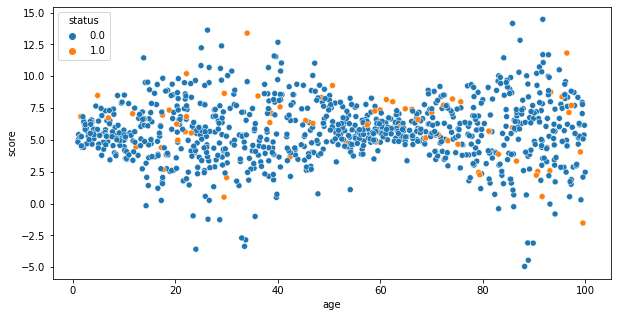

In [5]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df_het)

### Fit GAMLSS model on heteroskedastic data

In [6]:
# Initialize pynm w/ data, confounds, & bin parameters
m_het = PyNM(df_het,'score','status',['age'],
                bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [7]:
# Run models
m_het.loess_normative_model()
m_het.gp_normative_model(length_scale_bounds='fixed',length_scale=20)
m_het.gamlss_normative_model(mu = "score ~ cs(age)", sigma = "~ cs(age,df=2)", family='NO2')

/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:509: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:515: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


GAMLSS-RS iteration 1: Global Deviance = 4074.972 
GAMLSS-RS iteration 2: Global Deviance = 4074.981 
GAMLSS-RS iteration 3: Global Deviance = 4074.983 
GAMLSS-RS iteration 4: Global Deviance = 4074.971 
GAMLSS-RS iteration 5: Global Deviance = 4074.97 
GAMLSS-RS iteration 6: Global Deviance = 4074.97 
new prediction 
new prediction 


As we saw in tutorial 2, the simple LOESS strategy is effective whereas the GP fails to accurately estimate the CI for the heteroskedastic data resulting in skewed deviance scores. 

Here we've added the GAMLSS model which explicitly models the variance as a function of age. This strategy captures the change in variance smoothly and results in evenly distributed deviance scores across age, neatly handling the heteroskedasticity and non-gaussian noise.

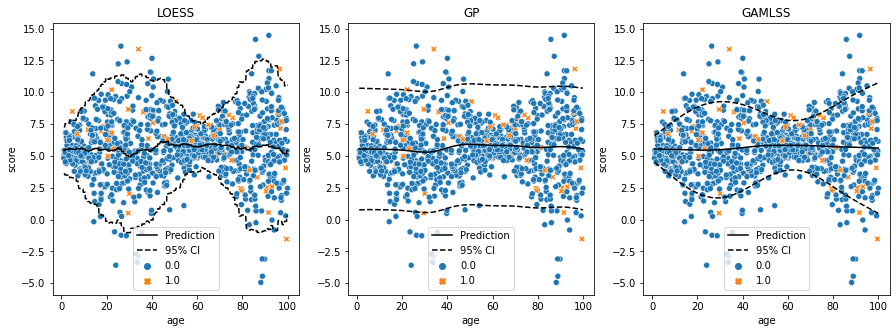

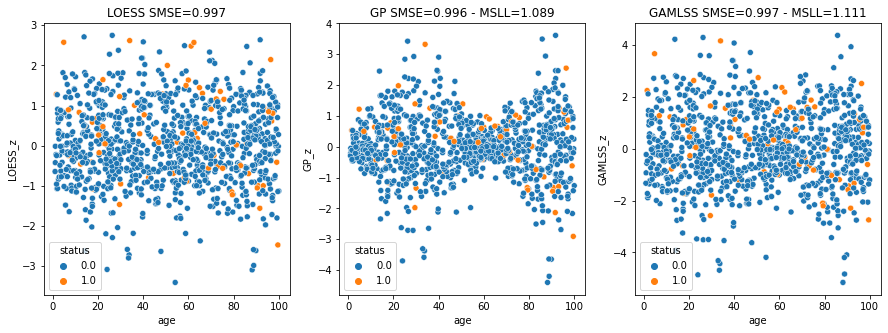

In [8]:
# Plot the data, model prediction, & 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='age')

## **Example 2**
Here we will implement the example and recommended model from the Dinga et al. preprint.

In [2]:
df = pd.read_csv('dinga_data.csv')
df['train_sample'] = 1
df.shape[0]

31821

In [10]:
m = PyNM(df,'Median_Thickness','train_sample',['age','c(site_id)'],train_sample=0.1)

Models will be fit with train sample size = 0.1: using 3182/31821 of controls.


In [11]:
m.gamlss_normative_model(mu = 'Median_Thickness ~ ps(age) + random(as.factor(site_id))',
                        sigma = '~ ps(age)+ random(as.factor(site_id))')

GAMLSS-RS iteration 1: Global Deviance = -7447.191 
GAMLSS-RS iteration 2: Global Deviance = -8012.933 
GAMLSS-RS iteration 3: Global Deviance = -8163.252 
GAMLSS-RS iteration 4: Global Deviance = -8221.665 
GAMLSS-RS iteration 5: Global Deviance = -8250.577 
GAMLSS-RS iteration 6: Global Deviance = -8266.003 
GAMLSS-RS iteration 7: Global Deviance = -8274.613 
GAMLSS-RS iteration 8: Global Deviance = -8279.496 
GAMLSS-RS iteration 9: Global Deviance = -8282.339 
GAMLSS-RS iteration 10: Global Deviance = -8284.04 
GAMLSS-RS iteration 11: Global Deviance = -8285.073 
GAMLSS-RS iteration 12: Global Deviance = -8285.789 
GAMLSS-RS iteration 13: Global Deviance = -8286.244 
GAMLSS-RS iteration 14: Global Deviance = -8286.554 
GAMLSS-RS iteration 15: Global Deviance = -8286.782 
GAMLSS-RS iteration 16: Global Deviance = -8287.594 
GAMLSS-RS iteration 17: Global Deviance = -8287.753 
GAMLSS-RS iteration 18: Global Deviance = -8287.85 
GAMLSS-RS iteration 19: Global Deviance = -8287.912 
GAML

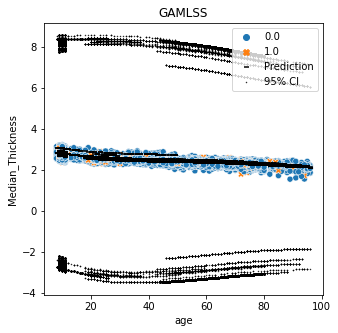

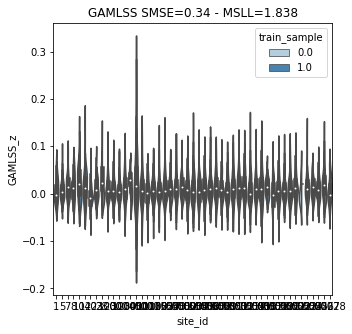

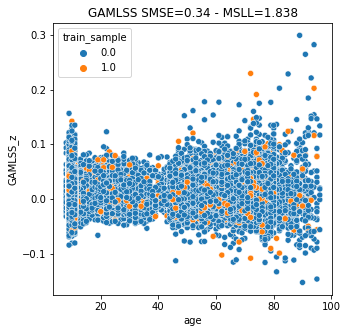

In [13]:
m.plot()

m.plot_z(confound='site_id')
m.plot_z(confound='age')